# Convert Chain to Function Automatically.

## Preliminaries

### Imports

In [1]:
import os
import pandas as pd
import sys
import networkx as nx

from functools import reduce
from os.path import dirname
from networkx.drawing.nx_pydot import to_pydot

note_dir = os.getcwd()

root_dir = dirname(note_dir)
src_dir = os.path.join(root_dir, "src")

sys.path.append(src_dir)

import morpheus
from morpheus.core import compose
from morpheus.tests import default_chain, default_ensemble, default_dataset
from morpheus.graph import (model_to_graph,
                            model_graph_traces,
                            model_graph_layout, 
                            convert_positions_to_dot_format,
                           add_merge_nodes)

In [2]:
from functools import partial

In [3]:
# In Greek to avoid nameclashes
ω = compose.o
χ = compose.x

### Functions

In [4]:
def fix_layout(G):
    
    for n in G.nodes():
        node = G.nodes(data=True)[n]
        if node['bipartite'] == 'func':
            node['shape'] = "\"square\""
            node['width'] = "1"
        elif node['bipartite'] == 'data':
            node['shape'] = "\"circle\""
        else:
            pass
    
    return G

In [5]:
import numpy as np

def select(idx):
    
    def select(X):
        if len(X.shape) > 1:
            return X[:, idx]
        elif len(X.shape) == 1:
            assert idx == 0
            return X
    return select

In [6]:
def convert_graph_to_functions(G):
    # Convert the graph to its functions
    sorted_list = list(nx.topological_sort(G))
    # print(sorted_list)
    functions = {}
    for node_name in sorted_list:
        node = G.nodes(data=True)[node_name]
        #print(node_name)
        if node.get('kind', None) == 'data': 
            if len(nx.ancestors(G, node_name)) == 0:
                functions[node_name] = select(node['idx'])
            else:

                # This is pretty much identical to what happens in the merge node
                previous_node = [t[0] for t in G.in_edges(node_name)][0] # I know it is just one
                previous_t_idx = G.nodes()[previous_node]['tgt'] 

                relevant_idx = previous_t_idx.index(node['idx'])

                functions[node_name] = ω(select(relevant_idx), functions[previous_node])


        elif node.get('kind', None) == 'model':

            previous_nodes = [t[0] for t in G.in_edges(node_name)]

            #print(functions.keys())
            inputs = [functions[n] for n in previous_nodes]
            inputs = ω(np.transpose, χ(*inputs, return_type=np.array))
            f = node['function']
            functions[node_name] = ω(f, inputs)

        elif node.get('kind', None) == 'merge':
            merge_idx = node['idx']
            previous_nodes = [t[0] for t in G.in_edges(node_name)]
            previous_t_idx = [G.nodes()[n]['tgt'] for n in previous_nodes]
            #print(previous_t_idx)
            inputs = [(functions[n],t) for n, t in zip(previous_nodes, previous_t_idx)]

            inputs = [ω(select(t_idx.index(merge_idx)), f) for f, t_idx in inputs]
            inputs = ω(np.transpose, χ(*inputs, return_type=np.array))

            f = partial(np.mean, axis=1)
            functions[node_name] = ω(f, inputs)
    return functions

In [26]:
def prune(g, tgt_nodes=None):
    
    if tgt_nodes is None:
        tgt_nodes = [n for n, out_degree in g.out_degree()
                     if out_degree == 0
                     if g.nodes()[n]['kind'] == 'data']
        print(tgt_nodes)
    else:
        assert isinstance(tgt_nodes, list)
        
    ancestors = [nx.ancestors(g, source=n) for n in tgt_nodes]
    ancestors = reduce(set.union, ancestors)
    
    
    
    nodes_to_remove = [n for n in g.nodes()
                       if n not in ancestors]
    for n in nodes_to_remove:
        g.remove_node(n)
    
    return g

In [8]:
def get_ids(g, kind='desc'):
    
    if kind in {'s', 'src', 'source', 'd', 'desc', 'descriptive'}:
        r = [g.nodes()[n]['idx'] for n, in_degree in g.in_degree
             if in_degree == 0
             if g.nodes()[n]['kind'] == 'data']
        
    elif kind in {'t', 'tgt', 'targ', 'target'}:
        r = [g.nodes()[n]['idx'] for n, in_degree in g.out_degree
             if out_degree == 0
             if g.nodes()[n]['kind'] == 'data']
    else:
        msg = """
        Did not recognize kind:   {}
        """.format(kind)
        raise ValueError(msg)
    
    return set(r)

### Ensemble

In [9]:
data, _ = default_dataset(random_state=16)
c = default_chain(random_state=16)


        Learning model with desc ids:    [0, 1, 2]
                            targ ids:    [4, 5]
        

        Learning model with desc ids:    [1, 2, 5]
                            targ ids:    [7]
        

            Trying to add a model to end of the chain.
            
            Current chain targ_ids:     [4. 5.]
            New estimator desc_ids:     [1, 2, 5]
            


            Connecting attributes:  [5.]
            



In [10]:
data.values.shape

(800, 8)

In [11]:
c.pretty_print()


        # Main
        Descriptive attributes:     [0. 1. 2.]
        Target attributes:          [4. 7.]

        ## On types (mostly nominals)
        Target attribute types:                     ['numeric', 'nominal']
        N_classes of nominal target attributes:     [2]
        Classes of nominal target attributes:       [array([0., 1.])]

        ## Weights
        Total weights of target attributes:         [1. 1.]

         
        ## Estimators
        Estimators used:        ['RandomForestRegressor', 'RandomForestClassifier']
        N_estimators:           2
        


## Build basic chain

In [12]:
G_one = model_to_graph(c.estimators_[0], idx=1)
G_two = model_to_graph(c.estimators_[1], idx=2)

G = nx.compose(G_one, G_two)
G = fix_layout(G)

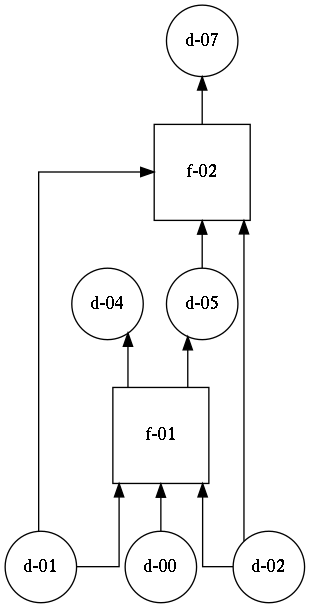

In [13]:
# plot
X = to_pydot(G)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

with open("tmp/test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png tmp/test.dot > tmp/test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('tmp/test.png', unconfined=True))

In [14]:
functions =  convert_graph_to_functions(G)
functions

{'d-02': <function __main__.select.<locals>.select(X)>,
 'd-01': <function __main__.select.<locals>.select(X)>,
 'd-00': <function __main__.select.<locals>.select(X)>,
 'f-01': <function morpheus.core.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'd-05': <function morpheus.core.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'f-02': <function morpheus.core.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'd-07': <function morpheus.core.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'd-04': <function morpheus.core.compose.o.<locals>.sequential_composition(*function_arguments)>}

In [15]:
a = functions['d-07'](data.values)
b = functions['f-02'](data.values)

In [16]:
np.unique(a-b, return_counts=True) # all zeroes, lgtm

(array([0.]), array([800]))

## Chain with useless crap

In [17]:
from morpheus.tests import default_m_list_for_mercs

In [18]:
m_list = default_m_list_for_mercs(data.values)


        Learning model with desc ids:    [0, 1, 2, 3, 4, 5, 7]
                            targ ids:    [6]
        
Unknown label type: 'continuous'

        Learning model with desc ids:    [1, 2, 3, 4, 5, 6, 7]
                            targ ids:    [0]
        

        Learning model with desc ids:    [0, 1, 3, 4, 5, 6, 7]
                            targ ids:    [2]
        

        Learning model with desc ids:    [0, 1, 2, 3, 4, 6, 7]
                            targ ids:    [5]
        

        Learning model with desc ids:    [0, 1, 2, 3, 5, 6, 7]
                            targ ids:    [4]
        

        Learning model with desc ids:    [0, 1, 2, 4, 5, 6, 7]
                            targ ids:    [3]
        

        Learning model with desc ids:    [0, 2, 3, 4, 5, 6, 7]
                            targ ids:    [1]
        

        Learning model with desc ids:    [0, 1, 2, 3, 4, 5, 6]
                            targ ids:    [7]
        


In [19]:
m_id = 0


m_list[0].desc_ids = [0,1,2]
m_list[0].targ_ids = [6]

print(m_list[0].desc_ids, m_list[0].targ_ids)

[0, 1, 2] [6]


In [20]:
g_stupid = model_to_graph(m_list[0], idx=3)
G = nx.compose(G, g_stupid)
G = fix_layout(G)

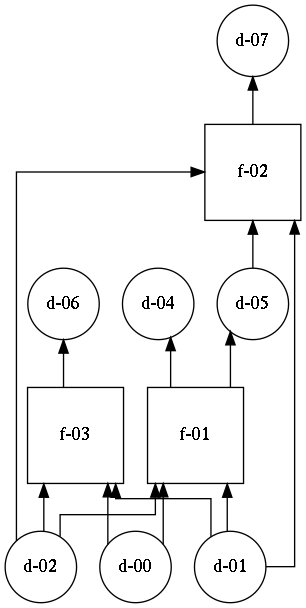

In [21]:
# plot
X = to_pydot(G)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

with open("tmp/test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png tmp/test.dot > tmp/test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('tmp/test.png', unconfined=True))

So now, what we want is to delete the unused models.

In [27]:
G = prune(G)

[]


TypeError: reduce() of empty sequence with no initial value

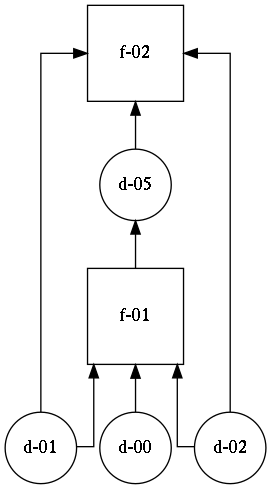

In [23]:
# plot
X = to_pydot(G)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

with open("tmp/test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png tmp/test.dot > tmp/test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('tmp/test.png', unconfined=True))

## Crazy chain

In [24]:
G_three = model_to_graph(model_two, idx=3)

NameError: name 'model_two' is not defined

In [ ]:
G_adv = nx.compose(G, G_three)
G_adv = fix_layout(G_adv)
add_merge_nodes(G_adv)

In [ ]:
X = to_pydot(G_adv)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

with open("test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png test.dot > test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('test.png', unconfined=True))

In [ ]:
f_adv = convert_graph_to_functions(G_adv)
f_adv

In [ ]:
f_adv['d-04'](data.values)

In [ ]:
data